In [1]:
import numpy as np
from dateutil.relativedelta import relativedelta
import datetime as dt
from datetime import date
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
import order_logs
import pricing

In [56]:
class strategies:
    
    def __init__(self,assets,equity,balance,tp,sl,order_book):
        self.assets = assets
        self.equity = equity
        self.balance = balance
        self.tp = tp
        self.sl = sl
        self.order_book = order_book
        
    def forex(self):
        
        ##### load pricing environment for data ######
        pricing_env = pricing.PricingEnvironment("Forex")
        file_names = ["XAUUSD_2023"]
        pricing_env.load_data_from_csv(file_names)  
        #################
        
        #### input specific to current strategy ######
        start_balance = 350
        lots = 1
        take_profit = 4
        stop_loss = 0
        trailing_stop_loss = 6
        trailing_stop_loss_activate = 1
        pip_step = 2
        tp = 0
        sl = 0
        tp_hit = 0
        sl_hit = 0
        self.equity.append(start_balance)
        self.balance.append(start_balance)
        wxau = [3, 5, 5]
        n_pos = 3
        indx_duration = 3000
        start_indx = 10000
        indx = start_indx
        order_type = 'BUY'
        fresh_order = 0
        ####################
        
        
#         assets = ['XAUUSD']
        in_positions = {}
        entry_prices = {}
        orders = {}
        index = {self.assets[0]: indx}   #timestamp 
        w8 = {self.assets[0]: [wxau[0]]}  #weights ==> update before placing new order
        order_id = {self.assets[0]: [1]}                
        current_price = pricing_env.get_open_price_for_index(indx)        
        order_log = order_logs.order_logistics(self.assets, in_positions, entry_prices, orders, order_id, current_price, index, w8)

        
        for i in range(indx_duration):
#             try:
            indx = start_indx + i
            order_log.current_price = pricing_env.get_open_price_for_index(indx)        

            ###### place fresh order ######
            if (fresh_order == 0):
                order_log.index = {self.assets[0]: indx}   #timestamp 
                if (order_type == 'BUY'):
                    order_log.w8 = {self.assets[0]: [wxau[0]]}
                else:
                    order_log.w8 = {self.assets[0]: [-wxau[0]]}
                order_log.order_place()
                print(indx,"Fresh order:",order_type,order_log.current_price,"Balance:",self.balance[-1],"Equity:",self.equity[-1])
                fresh_order = 1
                trailing_stop_loss_activate = 1
                sl_hit = 0
                tp_hit = 0
                current_profit = 0
            ##############

            #### profit calculation ###
            current_profit = order_log.order_profit()
            current_profit *= lots
            ###########

            self.equity.append(self.balance[-1]+current_profit)


            avg_price = 0
            total_quantity = 0
            for j in range(len(order_log.entry_prices[self.assets[0]])):
                avg_price += order_log.w8[self.assets[0]][j] * order_log.entry_prices[self.assets[0]][j]
                total_quantity += order_log.w8[self.assets[0]][j]
            avg_price /= total_quantity
            ############ trailing stop loss ############
            if trailing_stop_loss_activate == 1:
                if order_type == 'BUY':
                    if ((order_log.current_price[self.assets[0]] - avg_price) >= trailing_stop_loss/2):
                        trailing_stop_loss_activate = 2 
                        trailing_stop_loss_price = order_log.current_price[self.assets[0]] - trailing_stop_loss
                if order_type == 'SELL':
                    if ((avg_price - order_log.current_price[self.assets[0]]) >= trailing_stop_loss/2):
                        trailing_stop_loss_activate = 2 
                        trailing_stop_loss_price = order_log.current_price[self.assets[0]] + trailing_stop_loss

            if trailing_stop_loss_activate == 2:
                if order_type == 'BUY' and (order_log.current_price[self.assets[0]] - trailing_stop_loss_price) > trailing_stop_loss:
                    trailing_stop_loss_price = order_log.current_price[self.assets[0]] - trailing_stop_loss
                if order_type == 'SELL' and (trailing_stop_loss_price - order_log.current_price[self.assets[0]]) > trailing_stop_loss:
                    trailing_stop_loss_price = order_log.current_price[self.assets[0]] + trailing_stop_loss

            #############################


                ####################### trailing stop loss hit condition #############
                if (order_type == 'BUY'):
                    if ( order_log.current_price[self.assets[0]] - trailing_stop_loss_price < 0 ):
                        sl_hit = 1
                        order_log.index = {self.assets[0]: indx}   #timestamp 
                        order_log.order_clear()
                elif (order_type == 'SELL'):
                    if ( trailing_stop_loss_price - order_log.current_price[self.assets[0]] < 0 ):
                        sl_hit = 1
                        order_log.index = {self.assets[0]: indx}   #timestamp 
                        order_log.order_clear()

                if sl_hit == 1:
                    self.balance.append(self.balance[-1]+current_profit)
                    print(indx,"SL:",order_type,order_log.current_price[self.assets[0]],"Balance:",self.balance[-1],"Equity:",self.equity[-1],"Trade loss:",current_profit)
                    self.sl += 1
                    fresh_order = 0
                    sl_hit = 0
                    current_profit = 0
                    if order_type == 'BUY':
                        order_type = 'SELL'
                    else:
                        order_type = 'BUY'
                    continue
                ############## trailing stop loss condition over ##############


            ############# individual target condition ########
            # note: instead of average take individual target
            if (order_type == 'BUY'):
                if ( order_log.current_price[self.assets[0]] - avg_price ) >= take_profit:
                    tp_hit = 1
                    order_log.index = {self.assets[0]: indx}   #timestamp 
                    order_log.order_clear()
            elif (order_type == 'SELL'):
                if ( avg_price - order_log.current_price[self.assets[0]] ) >= take_profit:
                    tp_hit = 1
                    order_log.index = {self.assets[0]: indx}   #timestamp 
                    order_log.order_clear()

            if tp_hit == 1:
                self.balance.append(self.balance[-1]+current_profit)
                print(indx,"TP:",order_type,order_log.current_price[self.assets[0]],"Balance:",self.balance[-1],"Equity:",self.equity[-1],"Trade profit:",current_profit)
                self.tp += 1
                fresh_order = 0
                tp_hit = 0
                current_profit = 0
                continue
            ########################################

            ############# place new orders at pip step ############# trending market
            n_orders = len(order_log.entry_prices[self.assets[0]])
            if ( order_type == 'BUY' and (order_log.current_price[self.assets[0]] - order_log.entry_prices[self.assets[0]][-1]) >= pip_step and n_orders < n_pos and fresh_order == 1):
                order_log.index = {self.assets[0]: indx}   #timestamp 
                order_log.w8[self.assets[0]].append(wxau[n_orders])
                order_log.order_place()
                print(indx,"New order:",order_type,order_log.current_price[self.assets[0]],n_orders,"Balance:",self.balance[-1],"Equity:",self.equity[-1],"Current profit:",current_profit)
            elif ( order_type == 'SELL' and (order_log.entry_prices[self.assets[0]][-1] - order_log.current_price[self.assets[0]]) >= pip_step and n_orders < n_pos and fresh_order == 1):
                order_log.index = {self.assets[0]: indx}   #timestamp 
                order_log.w8[self.assets[0]].append(-wxau[n_orders])
                order_log.order_place()
                print(indx,"New order:",order_type,order_log.current_price[self.assets[0]],n_orders,"Balance:",self.balance[-1],"Equity:",self.equity[-1],"Current loss:",current_profit)
            ##########################

            ############## Entire trade end condition: lost $350 #########
            if (self.equity[-1] <= 0):
                order_log.index = {self.assets[0]: indx}   #timestamp 
                order_log.order_clear()
                self.balance.append(self.balance[-1]+current_profit)
                print(indx,"Trade cycle finish:",order_type,order_log.current_price[self.assets[0]],n_orders,"Balance:",self.balance[-1],"Equity:",self.equity[-1],"Trade profit:",current_profit)
                self.order_book = order_log.orders
                break
            ######################################

        self.order_book = order_log.orders
            
#             except Exception as e:
#                 print(f"Error: {e}")
        


In [57]:
# Start measuring CPU time
start_time = time.process_time()

assets = ['XAUUSD']
equity = []
balance = []
tp = 0
sl = 0
order_book = {}

strat = strategies(assets,equity,balance,tp,sl,order_book)
strat.forex()

# End measuring CPU time
cpu_time = time.process_time() - start_time
print("CPU Time:", cpu_time, "seconds")

Loaded data for asset 'XAUUSD' from XAUUSD_2023.csv with 308812 rows
10000 Fresh order: BUY {'XAUUSD': 1883.435} Balance: 350 Equity: 350
10393 New order: BUY 1885.585 1 Balance: 350 Equity: 356.4500000000003 Current profit: 6.450000000000273
10460 New order: BUY 1887.835 2 Balance: 350 Equity: 374.4500000000003 Current profit: 24.450000000000273
10532 TP: BUY 1891.748 Balance: 425.3190000000004 Equity: 425.3190000000004 Trade profit: 75.31900000000041
10533 Fresh order: BUY {'XAUUSD': 1893.948} Balance: 425.3190000000004 Equity: 425.3190000000004
10534 New order: BUY 1897.645 1 Balance: 425.3190000000004 Equity: 436.4100000000001 Current profit: 11.090999999999667
10553 TP: BUY 1900.265 Balance: 457.370000000001 Equity: 457.370000000001 Trade profit: 32.05100000000061
10554 Fresh order: BUY {'XAUUSD': 1900.895} Balance: 457.370000000001 Equity: 457.370000000001
11589 New order: BUY 1903.315 1 Balance: 457.370000000001 Equity: 464.63000000000125 Current profit: 7.260000000000218
11611 

In [58]:
strat.order_book

{'XAUUSD': [(1, 10000, 'BUY PLACED', [1883.435, 1885.585, 1887.835]),
  (2, 10393, 'BUY PLACED', [1883.435, 1885.585, 1887.835]),
  (3, 10460, 'BUY PLACED', [1883.435, 1885.585, 1887.835]),
  (1, 10532, 'BUY CLOSED', 1891.748),
  (2, 10532, 'BUY CLOSED', 1891.748),
  (3, 10532, 'BUY CLOSED', 1891.748),
  (4, 10533, 'BUY PLACED', [1893.948, 1897.645]),
  (5, 10534, 'BUY PLACED', [1893.948, 1897.645]),
  (4, 10553, 'BUY CLOSED', 1900.265),
  (5, 10553, 'BUY CLOSED', 1900.265),
  (6, 10554, 'BUY PLACED', [1900.895, 1903.315, 1905.415]),
  (7, 11589, 'BUY PLACED', [1900.895, 1903.315, 1905.415]),
  (8, 11611, 'BUY PLACED', [1900.895, 1903.315, 1905.415]),
  (6, 11622, 'BUY CLOSED', 1907.655),
  (7, 11622, 'BUY CLOSED', 1907.655),
  (8, 11622, 'BUY CLOSED', 1907.655),
  (9, 11623, 'BUY PLACED', [1907.555, 1910.878, 1912.975]),
  (10, 11989, 'BUY PLACED', [1907.555, 1910.878, 1912.975]),
  (11, 12041, 'BUY PLACED', [1907.555, 1910.878, 1912.975]),
  (9, 12045, 'BUY CLOSED', 1916.248),
  (10,

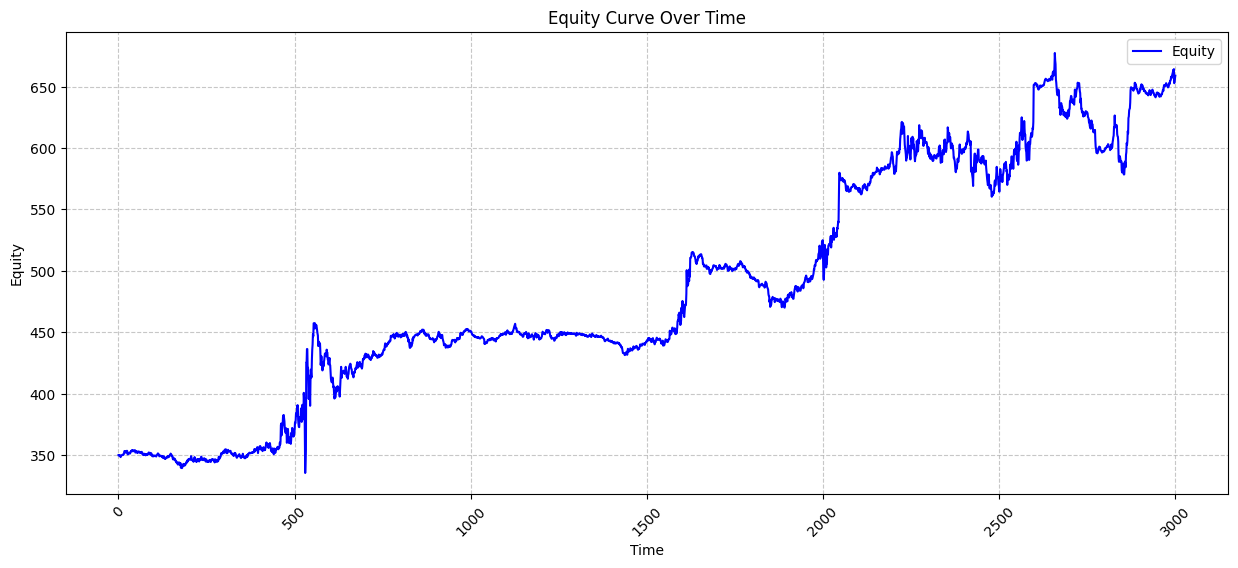

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(strat.equity, label='Equity', color='blue', linestyle='-')

plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity Curve Over Time')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.show()
